# Modelling the time evolution of COVID-19
### Marc Palomer
Modelització de Sistemes Biològics – Enginyeria Biomèdica UB
2019-20


### ABSTRACT
En el projecte següent hem modelitzat i simulat l’evolució en el temps de la Covid-19 a Japó. Utilitzant el model SIR (Susceptibles-Infectats-Recuperats) hem desenvolupat un codi de Python que ens ha permès veure i estudiar el comportament d’aquesta epidèmia en una regió geogràfica concreta. A partir de dades reals extretes de [1] hem estimat la taxa de reproducció (r) del nostre model, i hem fet una predicció de com evolucionarà l’epidèmia i quina forma es presentarà l’onada de casos amb la que em treballat. 


### INTRODUCCIÓ
Després dels últims anys de pandèmia que hem viscut, entenem força la importància dels models epidèmics com el SIR. Aquests models ens permeten preveure l’evolució dinàmica que adquirirà l’epidèmia i això ens pot ajudar a preparar-nos i poder afrontar millor una situació límit com les que hem presenciat en els darrers anys. 
Mitjançant eines computacionals podem estimar els paràmetres i variables que determinaran aquest comportament. A continuació, veurem un exemple aproximat de com es faria. Ho farem, com hem dit, modelitzant una de les onades de casos de Covid que es va donar a Japó durant els mesos de Maig-Juny-Juliol del 2020. 


### METODOLOGIA
La metodologia que hem emprat per esbrinar l’evolució de l’epidèmia a partir de les nostres dades, com ja hem comentat, ha estat la implementació del model SIR. Es tracta d’un model determinista continu en el temps, i es basa en la separació de la població en tres grups diferents, susceptibles (S), infectats (I) i recuperats (R) i diferents suposicions. Aquest model ve determinat per les equacions següents:

* dS/dt  =  -rSI/N

* dI/dt  =  rSI/N-aI

* dR/dt  =  aI


on r és la taxa de reproducció, la qual estimarem, i a és la taxa de recuperació, la qual vindrà determinada per 1/D on D=2.3 dies. 

A partir d’aquí, el que hem fet és condicionar les dades amb les que havíem de treballar i hem aplicat el model per predir-hi l’evolució d’aquestes. A continuació, veurem amb més detall els passos que hem seguit i els resultats que hem obtingut. 


### RESULTATS

In [1]:
#Importació de les llibreries

import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error


In [2]:
# Importació de les dades

data=pd.read_csv('covid_japan 2.csv', sep = ",")
data

FileNotFoundError: [Errno 2] No such file or directory: 'covid_japan 2.csv'

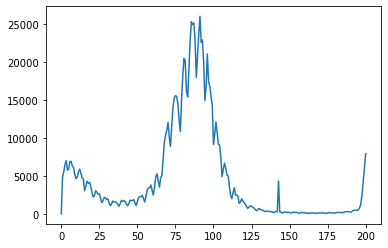

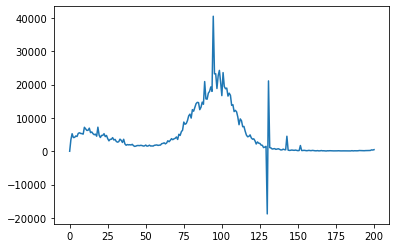

In [ ]:
#Separació de les dades en confirmats, morts i recuperats

confirmed=data["Confirmed"].tolist()
deaths=data["Fatal"].tolist()
recovered=data["Recovered"].tolist()

#Reducció de les dimensions

confirmed_reduced=confirmed[450:700]
deaths_reduced=deaths[450:700]
recovered_reduced=recovered[450:700]

#Desacumulació de les dades

confirmed_deacum=[]
recovered_deacum=[]

for i  in range(0,len(confirmed_reduced)-1):
    if i==0:
        confirmed_deacum.append(0)
        recovered_deacum.append(0)
    else:
        confirmed_deacum.append(confirmed_reduced[i]-confirmed_reduced[i-1])
        recovered_deacum.append(recovered_reduced[i]-recovered_reduced[i-1])

        
#Plot 

plt.figure(1)
t=np.linspace(0,200,len(confirmed_deacum))
plt.plot(t,confirmed_deacum)
plt.figure(2)
plt.plot(t,recovered_deacum)



    

Text(0.5, 1.0, 'Exploració visual recuperats 1a onada vs temps')

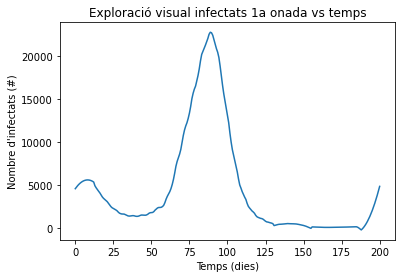

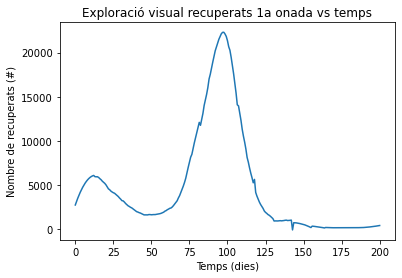

In [ ]:
#Aplicació del filtre Savitzky–Golay per a treure el soroll

confirmed_deacum_filt = savgol_filter(confirmed_deacum,31,2)
plt.figure(3)
plt.plot(t,confirmed_deacum_filt)
plt.xlabel('Temps (dies)')
plt.ylabel("Nombre d'infectats (#)")
plt.title("Exploració visual infectats 1a onada vs temps")


recovered_deacum_filt = savgol_filter(recovered_deacum,31,2)
plt.figure(4)
plt.plot(t,recovered_deacum_filt)
plt.xlabel('Temps (dies)')
plt.ylabel("Nombre de recuperats (#)")
plt.title("Exploració visual recuperats 1a onada vs temps")

Text(0.5, 1.0, 'Acotació exploració visual recuperats 1a onada vs temps')

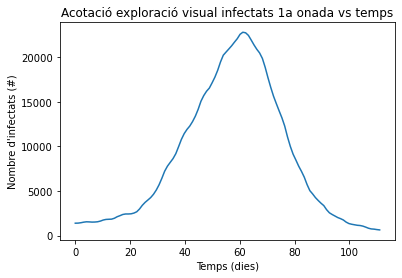

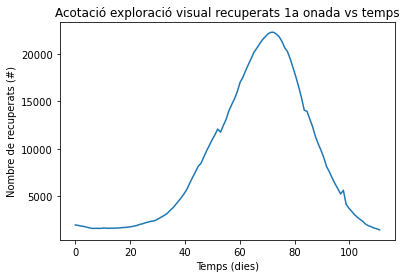

In [ ]:
#Acotació de les dades per quedar-nos només amb la corba (ho triem més o menys a ull)

confirmed_onada=confirmed_deacum_filt[50:160]
t=np.linspace(0,111,110)
plt.figure(5)
plt.plot(t,confirmed_onada)

plt.xlabel('Temps (dies)')
plt.ylabel("Nombre d'infectats (#)")
plt.title("Acotació exploració visual infectats 1a onada vs temps")



recovered_onada=recovered_deacum_filt[50:160]
t=np.linspace(0,111,110)
plt.figure(6)
plt.plot(t,recovered_onada)
plt.xlabel('Temps (dies)')
plt.ylabel("Nombre de recuperats (#)")
plt.title("Acotació exploració visual recuperats 1a onada vs temps")


In [ ]:
#Càlcul del punt màxim de la corba obtinguda

index_pic=np.argmax(confirmed_onada)
confirmed_pujada=confirmed_onada[0:index_pic]
t_pujada=t[0:index_pic]

Implementem el model SIR, fem bucle per diferents valors de r i N per trobar la millor combinació (S=N-I).

Comencem en un valor d'almenys una magnitud menys de la població total real. Perquè en el nostre model assumim que hi ha contacte de tots entre tots però això a la realitta no passa, la població està separada en "blocs". Una manera d'atenuar aquesta proximació és considerant una població molt més petita. 

In [ ]:
#FUNCIÓ DEL MODEL SIR

def sirmodel (ys_at_t,t,N,r,a):
    S,I,R=ys_at_t
    dSdt=-r * S * I/N
    dIdt= r * S * I/N - a * I
    dRdt= a * I
    return np.array([dSdt,dIdt,dRdt])   

In [ ]:
#DADES INICIALS
#N(Japó)=125 M

a=1/2.3
I0=confirmed_onada[0]
R0=recovered_onada[0]
N_list=np.linspace(35000,30000000,200)


#DEFINIM UN VECTOR DE r QUE TINGUI MÉS RESOLUCIÓ PER VALORS PETITS, ON SEGURAMENT ES TROVA EL VALOR D'INTERÉS

exp=np.linspace(-5,3,200)
r_list = [1*np.e**(i)for i in exp]


#GENEREM UN VECTOR DE TEMPS NECESSARI PER RESOLDRE LES ODEs

t1=np.linspace(0,61,110)


#CREEN LA MATRIU D'ERRRORS
#busquem la combinació que s'aproximi més a la corba real de infectats
#calcularem l'error amb RMS

error=np.zeros((len(N_list),len(r_list)))


#TROBEM ELS ERRORS PER A CADA COMBINACIÓ DE r I N

for i,r in enumerate(r_list):
    for k,pop in enumerate(N_list):
        S0 = pop-I0-R0
        Y0=[S0,I0,R0]
        #print(type(Y0[1]),type(t1[1]),type(N), type([r]), type(a))  --> això ens serviria per saber de quin tipus són
        Y=odeint(sirmodel,Y0,t1,args=(pop,r,a)) #El problema està a el temps
        I=Y[:,1]
        
        error[k,i]=m.sqrt(mean_squared_error(confirmed_pujada,I[0:index_pic]))
        error[k,i]= error[k,i]*(1+1*0.1*abs(np.argmax(confirmed_pujada)-np.argmax(I)))



In [ ]:
#De la matriu on hem guardat l'error de cada combinació de r i N, busquem el mínim
#Primer busquem el mínim de cada fila (N) i després el mínim absolut. 


for k in range(0,len(N_list)):
    for i in range(0,len(r_list)):
        if error[k,i]==error.min():
            r_best=r_list[i]
            N_best=N_list[k]

print("Model with minimum error: r = "+str(round(r_best,3))+ " N = "+str(round(N_best,2))+ " RMSE = "+str(round(error.min(),2)))



Model with minimum error: r = 0.561 N = 787889.45 RMSE = 2485.79


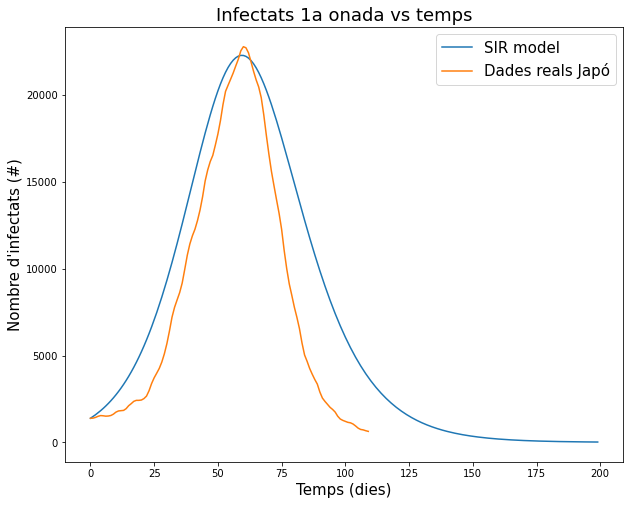

In [ ]:
#Corva amb els parametres ajustats
#N=90000000 

a=1/2.3
t=np.linspace(0,111,200)
I0=confirmed_onada[0]
R0 = recovered_onada[0]
S0 = N_best-I0-R0
Y0=[S0,I0,R0]
r=r_best


Y=odeint(sirmodel,Y0,t,args=(N_best,r_best,a))
Infected_best=Y[:,1]

plt.figure(figsize = (10,8))
plt.plot(Infected_best,label="SIR model")
plt.plot(confirmed_onada,label="Dades reals Japó")
plt.legend(loc="best",  fontsize = 15)


plt.xlabel('Temps (dies)',  fontsize = 15)
plt.ylabel("Nombre d'infectats (#)",  fontsize = 15)
plt.title("Infectats 1a onada vs temps",  fontsize = 18)
plt.show()



Test: És important veure com s'adequa el model a la realitat amb unes dades que no haguem fet servir per entrenarlo. El split que hem fet de les dades entre train i test, a partir del pic de casos infectats de les dades experimentals, serveix per això. Els dos parametres que estudiarem per veure la performance del model seran la diferència entre els pics màxims d'infectats i la diferència en dies entre el final de la pandemia real i el predit. Aquest final el definirem com el 5% dels casos que hi havia al pic.

Per tant, hem de calcular la diferència en infectats entre els màxims de les dues corves i la differència de temps en que s'acaba l'onada (5% del màxim)

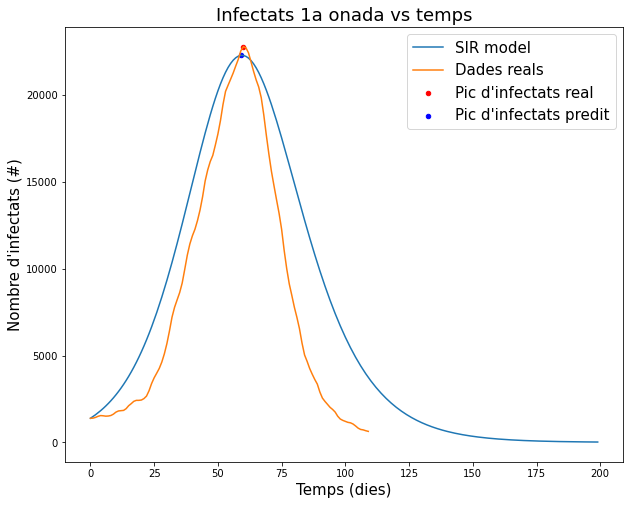

Diferència entre el pic d'infectats real i el predit:502.0 persones


In [ ]:
plt.figure(figsize = (10,8))
plt.plot(Infected_best,label="SIR model")
plt.plot(confirmed_onada,label="Dades reals")



#Punt màxim de la corva real
plt.scatter((confirmed_onada).argmax(), confirmed_onada.max(), s=20,color = 'r', label = "Pic d'infectats real")
#Punt màxim de la corva obtinguda amb el model
plt.scatter((Infected_best).argmax(), Infected_best.max(), s=20,color = 'b', label = "Pic d'infectats predit")

plt.legend(loc="upper right",  fontsize = 15)

plt.xlabel('Temps (dies)', fontsize = 15)
plt.ylabel("Nombre d'infectats (#)",  fontsize = 15)
plt.title("Infectats 1a onada vs temps", fontsize = 18)
plt.show()



#Calculem i imprimim la diferència entre els pics màxims de les dues corbes

print("Diferència entre el pic d'infectats real i el predit:{} persones".format(str(round(abs(confirmed_onada.max()-Infected_best.max()),0))))

Ara només queda veure quina és la diferència entre el dia on va acabar la pandemia i el dia on nosaltres hem predit que acabaria, amb el criteri de que s'acaba quan el nombre d'infectats és < 5% del nombre d'infectats que hi havia al pic.

[102, 1126.0749317423001]
[131, 1066.4104925917786]


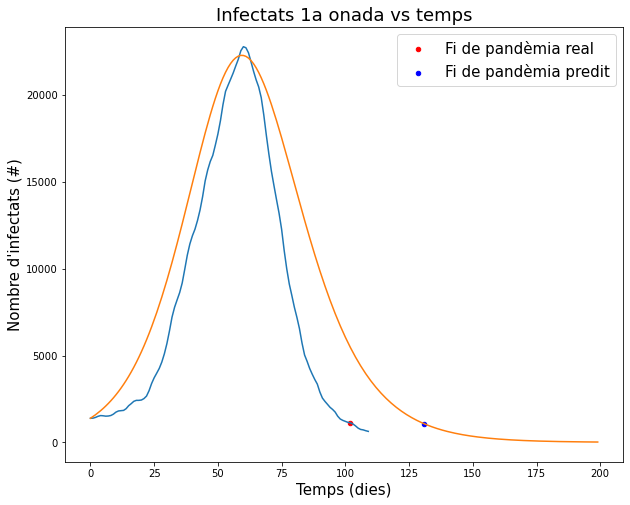

1139.7294822529682


In [ ]:
point_model = []
casos_005_model = Infected_best.max()*0.05
for index, element in enumerate(Infected_best[Infected_best.argmax():]):
    if element <= casos_005_model:
            point_model.append(index+Infected_best.argmax())
            point_model.append(element)
            
            break
            
point_data = []
casos_005_data = confirmed_onada.max()*0.05
for index_2, ele in enumerate(confirmed_onada[confirmed_onada.argmax():]):
    if ele <= casos_005_data:
            point_data.append(index_2+confirmed_onada.argmax())
            point_data.append(ele)
            
            break

print(point_data)
print(point_model)

plt.figure(figsize = (10,8))
plt.plot(confirmed_onada)
plt.plot(Infected_best)

plt.scatter(point_data[0], point_data[1], s=20,color = 'r', label = "Fi de pandèmia real")
plt.scatter(point_model[0], point_model[1], s=20,color = 'b', label = "Fi de pandèmia predit")

plt.legend(loc="upper right", fontsize = 15)
plt.xlabel('Temps (dies)', fontsize = 15)
plt.ylabel("Nombre d'infectats (#)", fontsize = 15)
plt.title("Infectats 1a onada vs temps", fontsize = 18)
plt.show()


len(Infected_best)
print(casos_005_data)

Predicció del final de la pandèmia vs el final real de la pandèmia, en dies

In [ ]:
dies = abs(point_model[0] - point_data[0])

print('La diferència entre les dades reals i el model són {} dies'.format(dies))

La diferència entre les dades reals i el model són 29 dies


### CONCLUSIÓ
Per concloure amb aquest treball, hem vist que el model SIR ha determinat el punt màxim de casos d’infectats amb prou exactitud. Com hem pogut veure als resultats, però, la predicció no coincideix del tot amb la forma real de l’epidèmia. Aquest fet és comprensible, ja que hem utilitzat un model simplificat, és a dir, hem fet moltes suposicions que no es van donar a la situació real d’on es van recollir les dades. Per exemple, no hem considerat el factor de la quarantena i les dades que hem estudiat eren d’un període de quarantena. És normal, doncs, que el model no sigui del tot fidel a la realitat. Tot i així, hem vist que ens ajuda a tenir una idea aproximada de com evoluciona l’epidèmia i, com hem dit, és una informació que ens pot ajudar molt en situacions de pandèmia.  


### BIBLIOGRAFIA
[1] Lisphilar. “COVID-19 Data with SIR Model.” Kaggle, Kaggle, 3 Apr. 2022, www.kaggle.com/code/lisphilar/covid-19-data-with-sir-model/data.
